This notebook shows a detailed EDA, Model Fitting and Hypertuning. Summary and Recommendations are available.

Hopefully, this notebook can be helpful to other Kagglers. :D
# Import libraries

In [1]:
import pandas as pd
from pandas_profiling import ProfileReport
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_validate, StratifiedKFold
from skopt.space import Real, Integer
from skopt import BayesSearchCV
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

pd.options.display.max_columns = None
%matplotlib inline

# Load the dataset

**Details from the dataset creator:**
- Education: 1 'Below College', 2 'College', 3 'Bachelor', 4 'Master', 5 'Doctor'
- EnvironmentSatisfaction: 1 'Low', 2 'Medium', 3 'High', 4 'Very High'
- JobInvolvement: 1 'Low', 2 'Medium', 3 'High', 4 'Very High'
- JobSatisfaction: 1 'Low', 2 'Medium', 3 'High', 4 'Very High'
- PerformanceRating: 1 'Low', 2 'Good', 3 'Excellent', 4 'Outstanding'
- RelationshipSatisfaction: 1 'Low', 2 'Medium', 3 'High', 4 'Very High'
- WorkLifeBalance: 1 'Bad', 2 'Good', 3 'Better', 4 'Best'

In [2]:
data = pd.read_csv('../input/hr-employee-attrition/HR Employee Attrition.csv')
data.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Y,Yes,11,3,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,Y,No,23,4,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Y,Yes,15,3,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,4,Female,56,3,1,Research Scientist,3,Married,2909,23159,1,Y,Yes,11,3,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,1,Male,40,3,1,Laboratory Technician,2,Married,3468,16632,9,Y,No,12,3,4,80,1,6,3,3,2,2,2,2


>As per checking, *EmployeeNumber* seems to be an identifier.

>Based on the description of the dataset from the creator, the following variables are ordinal: </br>
    *Education, EnvironmentSatisfaction, JobInvolvement, JobSatisfaction, PerformanceRating, RelationshipSatisfaction,* and *WorkLifeBalance*
    
>After checking the dataset, *JobLevel* and *StockOptionLevel* should also be ordinal.

# EDA
### Drop identifier and check for missing values

In [3]:
input_df = data.drop('EmployeeNumber', axis = 1)

# quick overview of the variables
input_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 34 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EnvironmentSatisfaction   1470 non-null   int64 
 10  Gender                    1470 non-null   object
 11  HourlyRate                1470 non-null   int64 
 12  JobInvolvement            1470 non-null   int64 
 13  JobLevel                  1470 non-null   int64 
 14  JobRole                 

### Check for variable(s) with constant value then remove if there exist

In [4]:
# variable(s) with constant value
val = input_df.apply(lambda x: len(x.unique()))
val[val ==1 ].index

Index(['EmployeeCount', 'Over18', 'StandardHours'], dtype='object')

In [5]:
input_df.drop(['EmployeeCount', 'Over18', 'StandardHours'], axis = 1, inplace = True)

## Categorical Variables
### Nominal Variables

In [6]:
# get categorical variables
nominal_df = input_df.select_dtypes(include=['object'])
nominal_df.head()

,Attrition,BusinessTravel,Department,EducationField,Gender,JobRole,MaritalStatus,OverTime
0,Yes,Travel_Rarely,Sales,Life Sciences,Female,Sales Executive,Single,Yes
1,No,Travel_Frequently,Research & Development,Life Sciences,Male,Research Scientist,Married,No
2,Yes,Travel_Rarely,Research & Development,Other,Male,Laboratory Technician,Single,Yes
3,No,Travel_Frequently,Research & Development,Life Sciences,Female,Research Scientist,Married,Yes
4,No,Travel_Rarely,Research & Development,Medical,Male,Laboratory Technician,Married,No


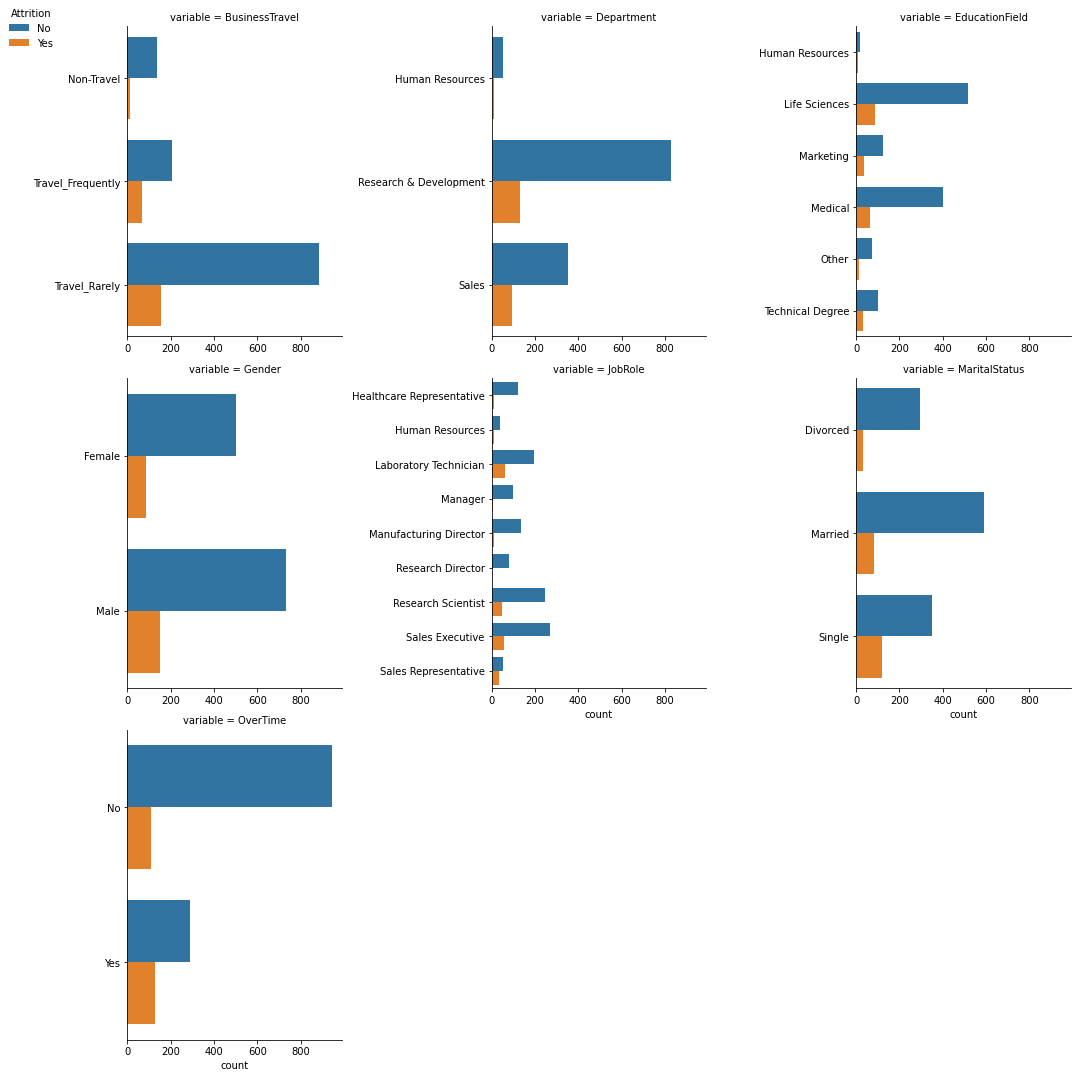

In [7]:
# count of category per variable
val = nominal_df.melt(value_name = 'category', id_vars = 'Attrition')\
    .groupby(['variable', 'category', 'Attrition']).size().to_frame('count').reset_index()
g = sns.catplot(
    data=val, x='count', y='category', col='variable', hue = 'Attrition', kind='bar', col_wrap=3,
    orient = 'h', sharey = False
)

# show x-label for all facet
for ax in g.axes.flatten():
    ax.tick_params(labelbottom=True)
    
sns.move_legend(g, 'upper left')
g.set(ylabel = None)

### Ordinal Variables

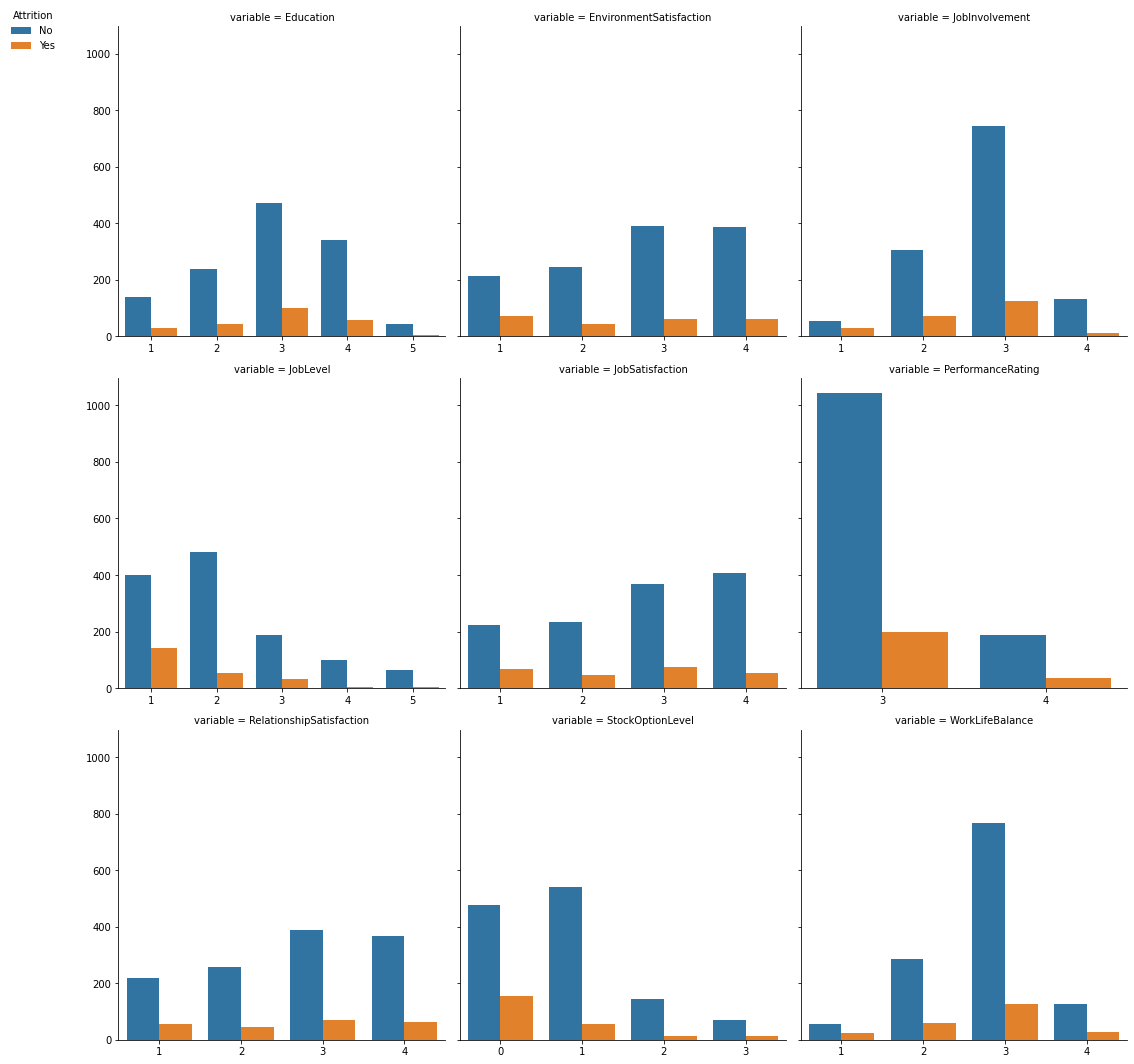

In [8]:
ordinal = ['Education', 'EnvironmentSatisfaction', 'JobLevel', 'JobInvolvement', 'JobSatisfaction', 'PerformanceRating', 'RelationshipSatisfaction', 'WorkLifeBalance', 'StockOptionLevel']
ordinal_df = input_df[ordinal]

val = pd.concat([input_df['Attrition'], ordinal_df], axis = 1)\
    .melt(value_name = 'category', id_vars = 'Attrition')\
    .groupby(['variable', 'category', 'Attrition']).size().to_frame('count').reset_index()
g = sns.catplot(
    data=val, x='category', y='count', col='variable', hue = 'Attrition', kind='bar', col_wrap=3,
    sharex = False
)

# show x-label for all facet
for ax in g.axes.flatten():
    ax.tick_params(labelbottom=True)
    
sns.move_legend(g, 'upper left', bbox_to_anchor=(-0.05, 1))
g.set(ylabel = None, xlabel = None)

## Numerical Variables

In [9]:
# Check numeric variables
numeric = input_df.describe().columns
num_df = input_df[numeric].reset_index(drop = True).drop(ordinal, axis = 1)
num_df.describe()

,Age,DailyRate,DistanceFromHome,HourlyRate,MonthlyIncome,MonthlyRate,NumCompaniesWorked,PercentSalaryHike,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
count,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000
mean,36.923810,802.485714,9.192517,65.891156,6502.931293,14313.103401,2.693197,15.209524,11.279592,2.799320,7.008163,4.229252,2.187755,4.123129
std,9.135373,403.509100,8.106864,20.329428,4707.956783,7117.786044,2.498009,3.659938,7.780782,1.289271,6.126525,3.623137,3.222430,3.568136
min,18.000000,102.000000,1.000000,30.000000,1009.000000,2094.000000,0.000000,11.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,30.000000,465.000000,2.000000,48.000000,2911.000000,8047.000000,1.000000,12.000000,6.000000,2.000000,3.000000,2.000000,0.000000,2.000000
50%,36.000000,802.000000,7.000000,66.000000,4919.000000,14235.500000,2.000000,14.000000,10.000000,3.000000,5.000000,3.000000,1.000000,3.000000
75%,43.000000,1157.000000,14.000000,83.750000,8379.000000,20461.500000,4.000000,18.000000,15.000000,3.000000,9.000000,7.000000,3.000000,7.000000
max,60.000000,1499.000000,29.000000,100.000000,19999.000000,26999.000000,9.000000,25.000000,40.000000,6.000000,40.000000,18.000000,15.000000,17.000000


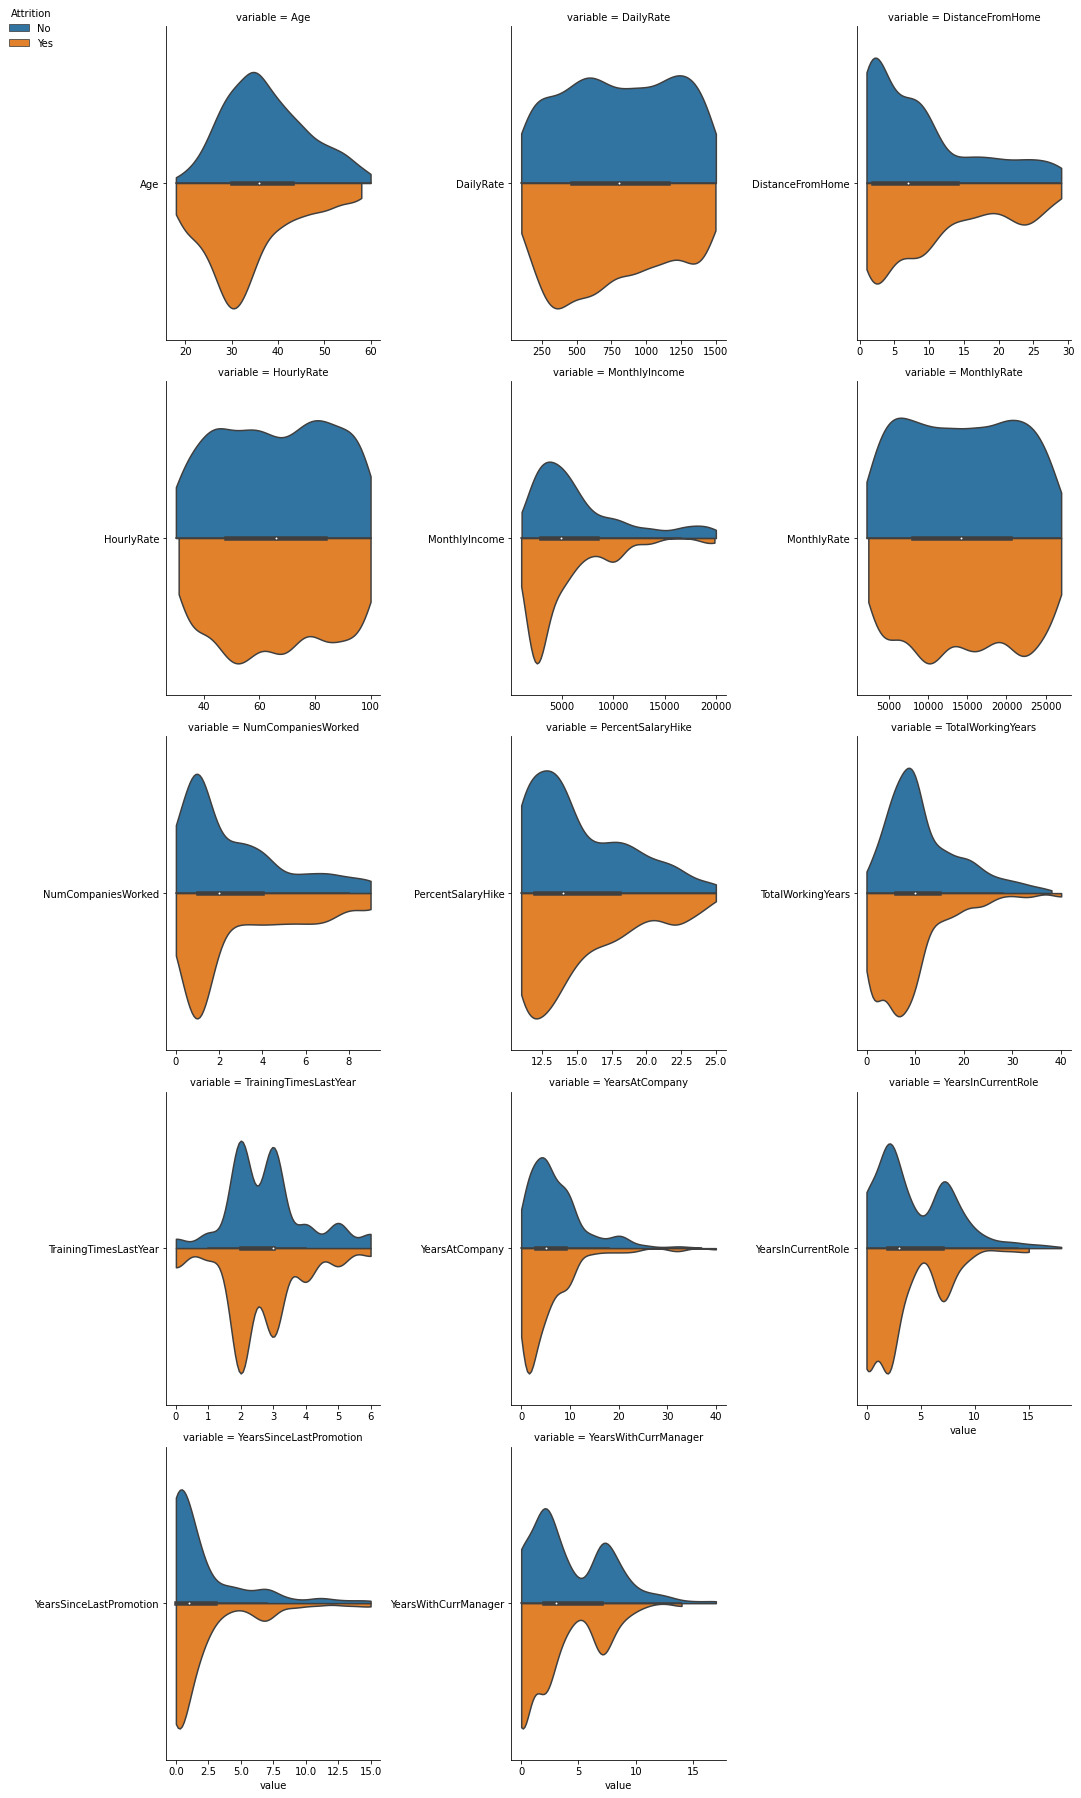

In [10]:
val = pd.concat([input_df['Attrition'], num_df], axis = 1)\
    .melt(value_name = 'value', id_vars = 'Attrition')

# compare the distribution of numeric features based on attrition
g = sns.catplot(
    data=val, x='value', y='variable', hue='Attrition', hue_order = ['No', 'Yes'],
    kind='violin', bw=.25, cut=0, split=True, col = 'variable', col_wrap = 3,
    sharey = False, sharex = False
)
g.set(ylabel=None)
sns.move_legend(g, 'upper left')

### Check for outliers

In [11]:
def outlier_summary(data):
    print(f'Count of outliers:')
    outlier_var = 0
    for val in data.columns:
        Q1,Q3 = np.percentile(data[val].sort_values(), [25,75])
        IQR = Q3 - Q1
        min_ = Q1 - (1.5 * IQR)
        max_ = Q3 + (1.5 * IQR)

        tagging = data[val].apply(lambda x: 1 if (x < min_ or x > max_) else 0)
        count = tagging[tagging == 1].sum()
        if count > 0: outlier_var = outlier_var + 1
        print(f'  {val} -- Count: {count} Percentage: {int(round(count/data.shape[0]*100, 0))}%')
    print(f'Total number of variables with outliers: {outlier_var}')
    
outlier_summary(num_df)

Count of outliers:
  Age -- Count: 0 Percentage: 0%
  DailyRate -- Count: 0 Percentage: 0%
  DistanceFromHome -- Count: 0 Percentage: 0%
  HourlyRate -- Count: 0 Percentage: 0%
  MonthlyIncome -- Count: 114 Percentage: 8%
  MonthlyRate -- Count: 0 Percentage: 0%
  NumCompaniesWorked -- Count: 52 Percentage: 4%
  PercentSalaryHike -- Count: 0 Percentage: 0%
  TotalWorkingYears -- Count: 63 Percentage: 4%
  TrainingTimesLastYear -- Count: 238 Percentage: 16%
  YearsAtCompany -- Count: 104 Percentage: 7%
  YearsInCurrentRole -- Count: 21 Percentage: 1%
  YearsSinceLastPromotion -- Count: 107 Percentage: 7%
  YearsWithCurrManager -- Count: 14 Percentage: 1%
Total number of variables with outliers: 8


>There are several ways of dealing with outliers depending on the data and possible cause. One can consider replacing the outliers with median or mode, deleting the observation(s) with outliers, discretizing/binning and winsorization/capping.

## Correlation of Numeric and Ordinal Variables
Spearman Correlation is a non-parametric test that can be used on continuous and ordinal variables

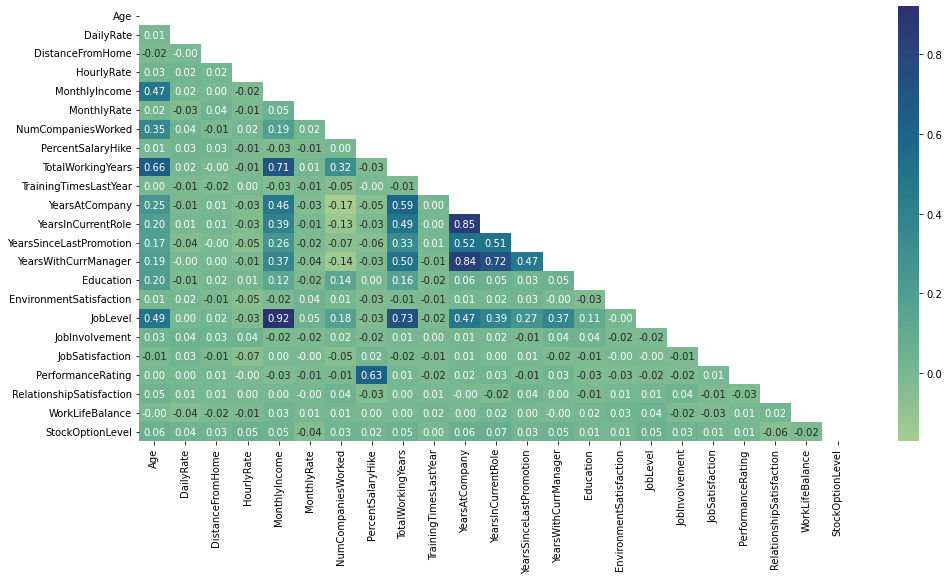

In [12]:
plt.figure(figsize = (16,8))

# check correlation of numerical variables using spearman
corr_mtrx= pd.concat([num_df, ordinal_df], axis =1).corr(method = 'spearman')
mask = np.triu(corr_mtrx)
sns.heatmap(corr_mtrx, annot=True, mask = mask, fmt = '.2f', cmap = 'crest')
plt.show()

The following variables have strong positive correlation:
- (any two) *MonthlyIncome*, *Job Level* and *TotalWorkingYears*
- (any two) *YearsInCurrentRole*, *YearsWithCurrManager* and *YearsAtCompany*

## Summary Based on EDA
- The total number of employees is 1470
- No missing values on the dataset.
- *EmployeeCount*, *Over18* and *StandardHours* have constant value. Hence, can be removed as a feature.
- Most of the employees:
    - are male
    - rarely have business travel
    - are in Research and Development
    - are from Life Sciences field followed by Medical field
    - do not overtime
- Attrition happens more
    - to single employees
    - to laboratory technician, sales executive and research scientist
    - to those with with business travel rarely
- Large number of employees have Bachelor Degree (3) and Master Degree (4)
- There are only two *PerformanceRating*, Excellent (3) and Outstanding (4)
- Huge number of employees have high (3) *JobInvolvement* and better (3) *WorkLifeBalance*
- Average age of employees is 36 and average monthly income is 6503
- Half of the employees live less than 7 kms from the office
- Based on the density plot of the numeric variables, distribution of employees who attrite and not, are almost the same except for *Age, MonthlyIncome, TotalWorkingYears, YearsAtCompany, YearInCurrentRole* and *YearsWithCurrManager*.
    - Most employees who attrite are on early 30s while most who stay are on mid 30s
    - Huge number of employees who leave have around 2500 monthly rate. Also, the length of stay in the company is more or less three 2.5 years

## Recommendation
- For further information and swift EDA, Panda's Profiling can be used.
```
    from pandas_profiling import ProfileReport
    ProfileReport(data, title='Profiling Report') 
```

- Chi-square Test of Independence can be used to check if the nominal features are associated with Attrition.
- Explore different methods on dealing with outiers.


# Data Split

In [13]:
# label encode the target variable
le = LabelEncoder()
y = pd.Series(le.fit_transform(input_df.Attrition))

In [14]:
label_summary = pd.DataFrame(zip(y, input_df.Attrition), columns = ['label_encode', 'Attrition'])\
    .groupby(['label_encode', 'Attrition']).size().to_frame('count').reset_index()
label_summary['%'] = round(label_summary['count']/label_summary['count'].sum()*100, 1)
label_summary

,label_encode,Attrition,count,%
0,0,No,1233,83.9
1,1,Yes,237,16.1


>As per checking, this is an imbalanced dataset. There are several ways to handle this such  as oversampling, undersampling and gathering more data. There are some who also deals with imbalanced dataset by using weights in their model. However, this notebook will not deal with it for now.

In [15]:
X_train, X_test, y_train, y_test = train_test_split(input_df.drop('Attrition', axis = 1), y, test_size = 0.2,
                                                    random_state = 778, shuffle = True, stratify = y)

# check distribution
pd.DataFrame({'Count - Train': y_train.value_counts(), '% - Train': round(y_train.value_counts(1)*100, 1),
              'Count - Test': y_test.value_counts(), '% - Test': round(y_test.value_counts(1)*100, 1)})

,Count - Train,% - Train,Count - Test,% - Test
0,986,83.8,247,84.0
1,190,16.2,47,16.0


# Preprocessing
## One Hot Encoding

In [16]:
from sklearn.compose import ColumnTransformer

In [17]:
nominal = X_train.select_dtypes(include=['object']).columns
ohe = ColumnTransformer([('encoder', OneHotEncoder(), nominal)], remainder='passthrough')

In [18]:
ohe.fit(X_train)
X_train_new = ohe.transform(X_train)
X_test_new = ohe.transform(X_test)

# Model Fitting

Models with default hyperparameters are fitted and evaluated using cross validation. Based on the result, model(s) to be hypertuned will be selected.

In [19]:
models = [SVC(), DecisionTreeClassifier(), RandomForestClassifier(), XGBClassifier(), LGBMClassifier()]
models_name = ['SVM', 'Decision Tree', 'Random Forest', 'XGBoost', 'LGBM']

for i in range(0, len(models)):
    cv_results = cross_validate(models[i], X_train_new, y_train,
                            cv=StratifiedKFold(n_splits= 5, shuffle=True, random_state=3),
                            scoring = ['f1_macro', 'accuracy'])
    accuracy = round(cv_results['test_accuracy'].mean(), 2)
    f1_score = round(cv_results['test_f1_macro'].mean(), 2)
    print(f'Model: {models_name[i]} - Accuracy: {accuracy} - F1 Score: {f1_score}')

Model: SVM - Accuracy: 0.84 - F1 Score: 0.46
Model: Decision Tree - Accuracy: 0.78 - F1 Score: 0.62
Model: Random Forest - Accuracy: 0.86 - F1 Score: 0.61
Model: XGBoost - Accuracy: 0.86 - F1 Score: 0.67
Model: LGBM - Accuracy: 0.87 - F1 Score: 0.67


>XGBoost and LGBM has the best performance. When working on imbalanced dataset, F1 Score is the recommended metric as it is the harmonic mean of the precision and recall.

# Hypertuning
LGBM will be hypertuned to improve its performance. XGBoost and/or Random Forest can also be hypertuned for comparison.

In [20]:
params = {'n_estimators': Integer(50, 150),
          'max_depth': Integer(3, 10),
          'learning_rate': Real(0.01, 1),
         'num_leaves': Integer(10, 20),
         'feature_fraction': Real(0.1, 0.9),
         'bagging_fraction': Real(0.8, 1),
         'min_data_in_leaf': Integer(20, 50)
         }

opt_cv = BayesSearchCV(LGBMClassifier(random_state = 2), params, n_iter = 5,
                      cv=StratifiedKFold(n_splits= 5, shuffle=True, random_state=3),
                      n_jobs = -1, scoring = 'f1_macro', refit = True,
                      random_state = 3, verbose = -1)

opt_cv.fit(X_train_new, y_train)

[LightGBM] [Warning] bagging_fraction is set=0.9619434436241066, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9619434436241066
[LightGBM] [Warning] feature_fraction is set=0.26438139671680827, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.26438139671680827
[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23


BayesSearchCV(cv=StratifiedKFold(n_splits=5, random_state=3, shuffle=True),
              estimator=LGBMClassifier(random_state=2), n_iter=5, n_jobs=-1,
              random_state=3, scoring='f1_macro',
              search_spaces={'bagging_fraction': Real(low=0.8, high=1, prior='uniform', transform='normalize'),
                             'feature_fraction': Real(low=0.1, high=0.9, prior='uniform', transform='normalize'),
                             'learning_...niform', transform='normalize'),
                             'max_depth': Integer(low=3, high=10, prior='uniform', transform='normalize'),
                             'min_data_in_leaf': Integer(low=20, high=50, prior='uniform', transform='normalize'),
                             'n_estimators': Integer(low=50, high=150, prior='uniform', transform='normalize'),
                             'num_leaves': Integer(low=10, high=20, prior='uniform', transform='normalize')},
              verbose=-1)

In [21]:
print(f' Best parameters: {opt_cv.best_params_}')
print(f' Best score: {round(opt_cv.best_score_, 2)}')

 Best parameters: OrderedDict([('bagging_fraction', 0.9619434436241066), ('feature_fraction', 0.26438139671680827), ('learning_rate', 0.9765494111698215), ('max_depth', 5), ('min_data_in_leaf', 23), ('n_estimators', 64), ('num_leaves', 12)])
 Best score: 0.7


# Model Evaluation

              precision    recall  f1-score   support

           0       0.89      0.95      0.92       247
           1       0.58      0.38      0.46        47

    accuracy                           0.86       294
   macro avg       0.74      0.67      0.69       294
weighted avg       0.84      0.86      0.84       294



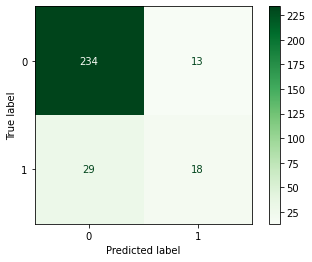

In [22]:
y_pred = opt_cv.predict(X_test_new)
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap = 'Greens')

>Based on the evaluation, LGBM increased its performance after hypertuning. The F1 Score is 0.69 from 0.67 while the Accuracy remains as 0.86. However, the model is unable to properly classify employees that will attrite.

>The model performance might improve by applying further preprocessing on the numerical variables, and addressing outliers and imbalanced dataset.